In [1]:
import os
import json
import pandas as pd
from deside.utility import (check_dir, sorted_cell_types)
from deside.utility.read_file import ReadExp, ReadH5AD
from deside.simulation import (BulkGEPGenerator, get_gene_list_for_filtering,
                               filtering_by_gene_list_and_pca_plot)

### Synthesizing bulk tumors
- Using the synthesis of a filtered bulk GEPs dataset with 10,000 samples as an example.
- Two filtering steps, GEP-filteirng and Gene-filtering, will be demonstrated.
- Instead of using the raw integrated scRNA-seq dataset `S0`, we will use the `S1` dataset directly.

- MacOS (this example): 6-Core Intel Core i5, 16 GB memory
- For larger sample size, more memory is needed, we synthesized dataset `D1` and `D2` on a computing server.

In [2]:
# the list of single cell RNA-seq datasets
sc_dataset_ids = ['hnscc_cillo_01', 'pdac_pengj_02', 'hnscc_puram_03',
                  'pdac_steele_04', 'luad_kim_05', 'nsclc_guo_06', 'pan_cancer_07']

# the list of cancer types in the TCGA dataset
cancer_types = ['ACC', 'BLCA', 'BRCA', 'GBM', 'HNSC', 'LGG', 'LIHC', 'LUAD', 'PAAD', 'PRAD',
                'CESC', 'COAD', 'KICH', 'KIRC', 'KIRP', 'LUSC', 'READ', 'THCA', 'UCEC']

# the list of cell types
all_cell_types = sorted_cell_types
all_cell_types

['B Cells',
 'CD4 T',
 'CD8 T',
 'Cancer Cells',
 'DC',
 'Endothelial Cells',
 'Fibroblasts',
 'Macrophages',
 'Mast Cells',
 'NK',
 'Neutrophils']

#### Parameters

In [3]:
# parameters
# for gene-level filtering
gene_list_type = 'high_corr_gene_and_quantile_range'
gene_quantile_range = [0.05, 0.5, 0.95]  # gene-level filtering

# for GEP-level filtering
gep_filtering_quantile = (0.0, 0.95)  # GEP-level filtering, L1-norm threshold
n_base = 100  # averaging 100 GEPs sampled from S1 to synthesize 1 bulk GEP, used by S1 generation

# optional, if set a prior cell proportion range for each cell type, the GEP-filtering step will be faster, default is (0, 1)
# It can be set as cell_prop_prior = {'B Cells': (0, 0.25), 'CD4 T': (0, 0.25), 'CD8 T': (0, 0.25),
#                    'DC': (0, 0.1), 'Mast Cells': (0, 0.1), 'NK': (0, 0.1), 'Neutrophils': (0, 0.1),
#                    'Endothelial Cells': (0, 0.5), 'Fibroblasts': (0, 0.5), 'Macrophages': (0, 0.5),
#                    'Cancer Cells': (0, 1)}
cell_prop_prior = None
dataset2parameters = {
    'Mixed_N10K_segment': {
        'sc_dataset_ids': sc_dataset_ids,
        'cell_types': all_cell_types,
        'n_samples': 10000,
        'sampling_method': 'segment', # or `random` used by Scaden
        'filtering': True,
    }
}

for ds, params in dataset2parameters.items():
    if ('filtering' in params) and ('filtering_ref_types' not in params):
        if params['filtering']:
            params['filtering_ref_types'] = cancer_types
        else:
            params['filtering_ref_types'] = None
print(json.dumps(dataset2parameters, indent=2))

{
  "Mixed_N10K_segment": {
    "sc_dataset_ids": [
      "hnscc_cillo_01",
      "pdac_pengj_02",
      "hnscc_puram_03",
      "pdac_steele_04",
      "luad_kim_05",
      "nsclc_guo_06",
      "pan_cancer_07"
    ],
    "cell_types": [
      "B Cells",
      "CD4 T",
      "CD8 T",
      "Cancer Cells",
      "DC",
      "Endothelial Cells",
      "Fibroblasts",
      "Macrophages",
      "Mast Cells",
      "NK",
      "Neutrophils"
    ],
    "n_samples": 10000,
    "sampling_method": "segment",
    "filtering": true,
    "filtering_ref_types": [
      "ACC",
      "BLCA",
      "BRCA",
      "GBM",
      "HNSC",
      "LGG",
      "LIHC",
      "LUAD",
      "PAAD",
      "PRAD",
      "CESC",
      "COAD",
      "KICH",
      "KIRC",
      "KIRP",
      "LUSC",
      "READ",
      "THCA",
      "UCEC"
    ]
  }
}


#### Input files
- `merged_tpm.csv`: Gene expression profiles (GEPs) of 19 cancer types in TCGA (TPM format). Download link: https://doi.org/10.6084/m9.figshare.23047547.v1
- `tcga_sample_id2cancer_type.csv`: An annotation file that contains the cancer type for each sample id of above 19 cancer types.
- `simu_bulk_exp_SCT_N10K_S1.h5ad`: Dataset S1, which contains the synthesized single-cell GEPs (scGEPs). Download link: https://doi.org/10.6084/m9.figshare.23043560.v1

In [4]:
# Using TCGA as reference GEPs to filter synthetic GEPs 
tcga_data_dir = r'./datasets/TCGA/tpm/'  # input
tcga_merged_tpm_file_path = os.path.join(tcga_data_dir, 'merged_tpm.csv')
tcga2cancer_type_file_path = os.path.join(tcga_data_dir, 'tcga_sample_id2cancer_type.csv')

In [5]:
# the file path of the dataset `S1`
sct_dataset_file_path = './datasets/simu_bulk_exp_SCT_N10K_S1.h5ad'

In [6]:
# naming the file of filtered bulk cell dataset
q_names = ['q_' + str(int(q * 1000)/10) for q in gene_quantile_range]
replace_by = f'_filtered_by_{gene_list_type}.h5ad'
high_corr_gene_list = []
if 'quantile_range' in gene_list_type:
    replace_by = f'_filtered_by_{gene_list_type}_{q_names[0]}_{q_names[2]}.h5ad'
replace_by

'_filtered_by_high_corr_gene_and_quantile_range_q_5.0_q_95.0.h5ad'

In [7]:
sampling_method2dir = {
    'random': os.path.join('results', 'E3', '{}_{}ds_n_base{}'),
    'segment': os.path.join('results', 'E3', '{}_{}ds_{}_n_base{}_median_gep'),
}

#### Bulk GEP generation and GEP-filtering
- This step will take about 3 hours for 10,000 samples

In [8]:
n_sc_datasets = len(sc_dataset_ids)
dataset2path = {}
log_file_path = './results/E3/DeSide_running_log.txt'
for dataset_name, params in dataset2parameters.items():
    if 'SCT' in dataset_name:
        pass  # using `S1` directly, omit this step here
    else:
        sampling_method = params['sampling_method']
        # the folder of simulated bulk cells
        simu_bulk_exp_dir = sampling_method2dir[sampling_method]
        if sampling_method in ['segment']:
            simu_bulk_exp_dir = simu_bulk_exp_dir.format(sampling_method, n_sc_datasets,
                                                         gep_filtering_quantile[1], n_base)
        else:  # 'random'
            simu_bulk_exp_dir = simu_bulk_exp_dir.format(sampling_method, n_sc_datasets, n_base)
        check_dir(simu_bulk_exp_dir)
        bulk_generator = BulkGEPGenerator(simu_bulk_dir=simu_bulk_exp_dir,
                                          merged_sc_dataset_file_path=None,
                                          cell_types=params['cell_types'],
                                          sc_dataset_ids=params['sc_dataset_ids'],
                                          bulk_dataset_name=dataset_name,
                                          sct_dataset_file_path=sct_dataset_file_path,
                                          check_basic_info=False,
                                          tcga2cancer_type_file_path=tcga2cancer_type_file_path)
        # GEP-filtering will be performed during this generation process
        generated_bulk_gep_fp = bulk_generator.generated_bulk_gep_fp
        dataset2path[dataset_name] = generated_bulk_gep_fp
        if not os.path.exists(generated_bulk_gep_fp):
            bulk_generator.generate_gep(n_samples=params['n_samples'],
                                        simu_method='mul',
                                        sampling_method=params['sampling_method'],
                                        reference_file=tcga_merged_tpm_file_path,
                                        ref_exp_type='TPM',
                                        filtering=params['filtering'],
                                        filtering_ref_types=params['filtering_ref_types'],
                                        gep_filtering_quantile=gep_filtering_quantile,
                                        n_threads=5,
                                        log_file_path=log_file_path,
                                        show_filtering_info=False,
                                        filtering_method='median_gep',
                                        cell_prop_prior=cell_prop_prior)

   > 7699 samples in ACC, BLCA, BRCA, GBM, HNSC, LGG, LIHC, LUAD, PAAD, PRAD, CESC, COAD, KICH, KIRC, KIRP, LUSC, READ, THCA, UCEC are used for median_gep filtering.


  0%|                                                 | 0/10000 [00:00<?, ?it/s]

12114 common genes will be used, 7598 genes will be removed.


100%|███████████████████████████████████| 10000/10000 [2:37:04<00:00,  1.06it/s]


   > Got 10000 samples from 230000 within l1 distance between 310007.8190000002 and 668987.093099999 by quantile 0.0%-95.0%

---->>> <class 'deside.simulation.generate_data.BulkGEPGenerator'>:
{
  "simu_bulk_dir": "results/E3/segment_7ds_0.95_n_base100_median_gep",
  "cell_type_used": [
    "B Cells",
    "CD4 T",
    "CD8 T",
    "Cancer Cells",
    "DC",
    "Endothelial Cells",
    "Fibroblasts",
    "Macrophages",
    "Mast Cells",
    "NK",
    "Neutrophils"
  ],
  "sc_dataset_used": [
    "hnscc_cillo_01",
    "pdac_pengj_02",
    "hnscc_puram_03",
    "pdac_steele_04",
    "luad_kim_05",
    "nsclc_guo_06",
    "pan_cancer_07"
  ],
  "bulk_dataset_name": "Mixed_N10K_segment",
  "n_samples": 10000,
  "generated_bulk_gep_counter": 10000,
  "n_round": 46,
  "total_cell_number": 1,
  "filtering_quantile_upper": 0.95,
  "filtering_quantile_lower": 0.0,
  "generated_cell_fraction_fp": "results/E3/segment_7ds_0.95_n_base100_median_gep/generated_frac_Mixed_N10K_segment.csv",
  "ref_neig

#### Gene-filtering
- Highly correlated genes between the gene expression values and the cell proportions for each cell type
- Using the same gene list given by dataset D2

In [9]:
d2_dir = './datasets/simulated_bulk_cell_dataset/D2/'
high_corr_gene_file_path = os.path.join(d2_dir, f'gene_list_filtered_by_high_corr_gene.csv')
# if not os.path.exists(high_corr_gene_file_path):
#     print(f'High correlation gene list will be saved in: {high_corr_gene_file_path}')
#     high_corr_gene_list = get_gene_list_for_filtering(bulk_exp_file=generated_bulk_gep_fp,
#                                                       filtering_type='high_corr_gene',
#                                                       corr_result_fp=corr_result_fp,
#                                                       tcga_file=tcga_merged_tpm_file_path,
#                                                       quantile_range=gene_quantile_range,
#                                                       result_file_path=high_corr_gene_file_path,
#                                                       corr_threshold=0.3, n_gene_max=1000)
# else:
#     print(f'High correlation gene list file existed: {high_corr_gene_file_path}')
high_corr_gene_list = pd.read_csv(high_corr_gene_file_path)
high_corr_gene_list = high_corr_gene_list['gene_name'].to_list()
len(high_corr_gene_list)

7630

In [10]:
dataset_name = 'Mixed_N10K_segment'
params = dataset2parameters[dataset_name]

Gene list of Mixed_N10K_segment will be saved in: results/E3/segment_7ds_0.95_n_base100_median_gep/Mixed_N10K_segment/gene_list_filtered_by_high_corr_gene_and_quantile_range_q_5.0_q_95.0.csv
12114 common genes will be used, 7598 genes will be removed.
9479 genes are selected by quantile range
Filtering by gene list and PCA plot
6187 common genes will be used, 5927 genes will be removed.
6187 common genes will be used, 13525 genes will be removed.
Saving filtered bulk exp to file: results/E3/segment_7ds_0.95_n_base100_median_gep/simu_bulk_exp_Mixed_N10K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_5.0_q_95.0.h5ad
Saving as .h5ad file...


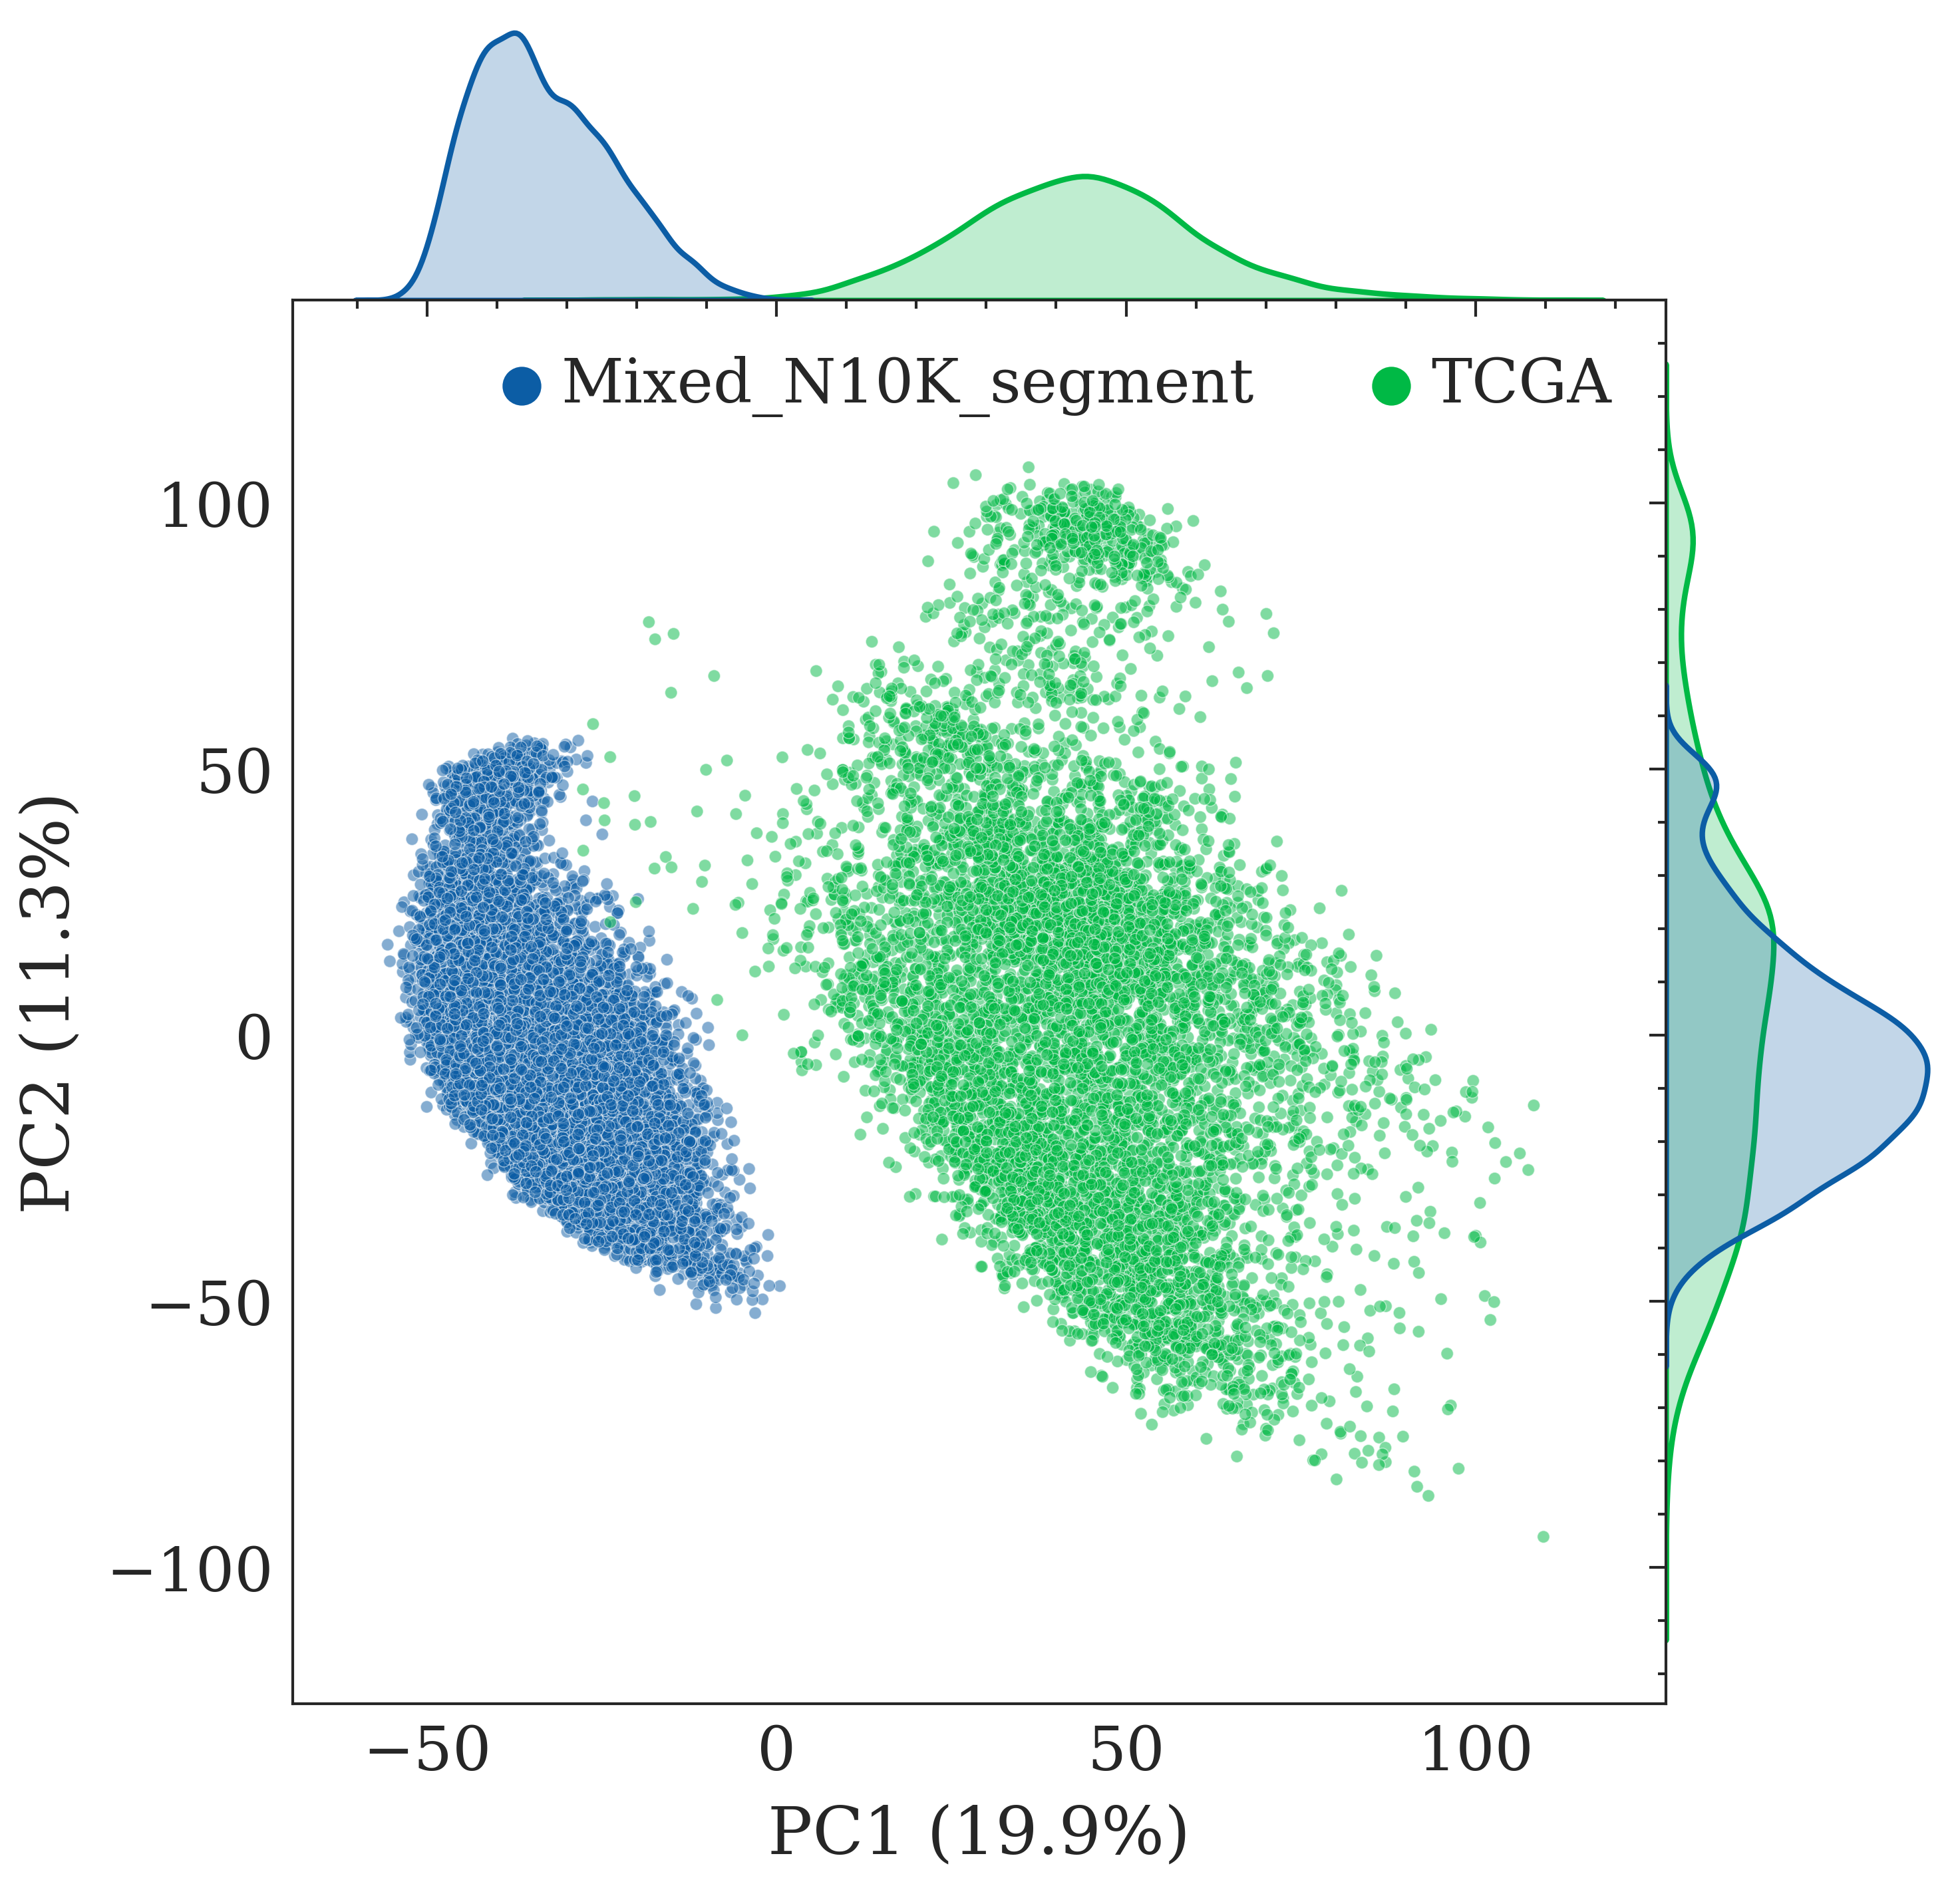

In [11]:
# gene-level filtering that depends on the high correlation genes and quantile range (each dataset itself)
if params['filtering']:
    filtered_file_path = generated_bulk_gep_fp.replace('.h5ad', replace_by)
    if not os.path.exists(filtered_file_path):
        gene_list = high_corr_gene_list.copy()
        # get gene list, filtering, PCA and plot
        current_result_dir = os.path.join(simu_bulk_exp_dir, dataset_name)
        check_dir(current_result_dir)
        # the gene list file for current dataset
        if 'quantile_range' in gene_list_type:
            gene_list_file_path = os.path.join(simu_bulk_exp_dir, dataset_name, f'gene_list_filtered_by_{gene_list_type}.csv')
            gene_list_file_path = gene_list_file_path.replace('.csv', f'_{q_names[0]}_{q_names[2]}.csv')
            if not os.path.exists(gene_list_file_path):
                print(f'Gene list of {dataset_name} will be saved in: {gene_list_file_path}')
                quantile_gene_list = get_gene_list_for_filtering(bulk_exp_file=generated_bulk_gep_fp,
                                                                 filtering_type='quantile_range',
                                                                 tcga_file=tcga_merged_tpm_file_path,
                                                                 quantile_range=gene_quantile_range,
                                                                 result_file_path=gene_list_file_path,
                                                                 q_col_name=q_names)
            else:
                print(f'Gene list file existed: {gene_list_file_path}')
                quantile_gene_list = pd.read_csv(gene_list_file_path)
                quantile_gene_list = quantile_gene_list['gene_name'].to_list()
            # get the intersection of the two gene lists (high correlation genes and within quantile range)
            gene_list = [gene for gene in gene_list if gene in quantile_gene_list]
        bulk_exp_obj = ReadH5AD(generated_bulk_gep_fp)
        bulk_exp = bulk_exp_obj.get_df()
        bulk_exp_cell_frac = bulk_exp_obj.get_cell_fraction()
        tcga_exp = ReadExp(tcga_merged_tpm_file_path, exp_type='TPM').get_exp()
        pc_file_name = f'both_TCGA_and_simu_data_{dataset_name}'
        pca_model_file_path = os.path.join(current_result_dir, f'{pc_file_name}_PCA_{gene_list_type}.joblib')
        pca_data_file_path = os.path.join(current_result_dir, f'{dataset_name}_PCA_with_TCGA_{gene_list_type}.csv')
        # save GEPs data by filtered gene list
        print('Filtering by gene list and PCA plot')
        filtering_by_gene_list_and_pca_plot(bulk_exp=bulk_exp, tcga_exp=tcga_exp, gene_list=gene_list,
                                            result_dir=current_result_dir, n_components=2,
                                            simu_dataset_name=dataset_name,
                                            pca_model_name_postfix=gene_list_type,
                                            pca_model_file_path=pca_model_file_path,
                                            pca_data_file_path=pca_data_file_path,
                                            h5ad_file_path=filtered_file_path,
                                            cell_frac_file=bulk_exp_cell_frac,
                                            figsize=(5, 5))

#### Output files
```text
results/E3  # the output folder of this example
|-- DeSide_running_log.txt  # log file
`-- segment_7ds_0.95_n_base100_median_gep
    |-- Mixed_N10K_segment
    |   |-- Mixed_N10K_segment_PCA_with_TCGA_high_corr_gene_and_quantile_range.csv  # Values of the first two principal components (PCs)
    |   |-- Mixed_N10K_segment_PCA_with_TCGA_high_corr_gene_and_quantile_range_PC0_PC1.png  # Visualization of PCA for the generated dataset and TCGA
    |   `-- gene_list_filtered_by_high_corr_gene_and_quantile_range_q_5.0_q_95.0.csv  # Gene list after filtering by correlation and quantile range
    |-- generated_frac_Mixed_N10K_segment.csv  # Cell proportion matrix
    |-- simu_bulk_exp_Mixed_N10K_segment_log2cpm1p.csv  # Generated bulk gene expression profiles (GEPs) without filtering (csv format)
    |-- simu_bulk_exp_Mixed_N10K_segment_log2cpm1p.h5ad  # Generated bulk GEPs without filtering (h5ad format)
    |-- simu_bulk_exp_Mixed_N10K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_5.0_q_95.0.h5ad  # Generated bulk GEPs after filtering (h5ad format)
    `-- simu_bulk_exp_Mixed_N10K_segment_sampled_sc_cell_id.csv  # Selected single-cell GEPs from dataset S1 during GEP sampling
```